In [51]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- CONFIGURARE STIL ---
sns.set_context("notebook", font_scale=1.2)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14

HOUSES = ['House1', 'House2']
print("Biblioteci incarcate. Stil configurat.")

Biblioteci incarcate. Stil configurat.


In [52]:
results_data = []

print("Incarcare rezultate...", end=" ")

for house in HOUSES:
    filename = f'results_{house}.pkl'
    try:
        with open(filename, 'rb') as f:
            data = pickle.load(f)
            
        y_true = data['y_true']
        preds = data['rezultate']
        times = data['timpi']
        
        for model_name, y_pred in preds.items():
            # Asiguram ca dimensiunile coincid
            if len(y_pred) != len(y_true):
                min_len = min(len(y_pred), len(y_true))
                y_pred = y_pred[:min_len]
                y_true_cut = y_true[:min_len]
            else:
                y_true_cut = y_true
                
            # Calcul Metrici
            mae = mean_absolute_error(y_true_cut, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true_cut, y_pred))
            time_sec = times.get(model_name, 0)
            
            results_data.append({
                'Casa': house,
                'Model': model_name,
                'MAE (W)': mae,
                'RMSE': rmse,
                'Timp (s)': time_sec
            })
            
    except FileNotFoundError:
        print(f"\n[ATENTIE] Fisierul {filename} lipseste! Asigura-te ca ai rulat Notebook-ul 2.")

# Creare DataFrame
df_results = pd.DataFrame(results_data)
print("GATA!")


Incarcare rezultate... GATA!


In [53]:
# Sortam dupa Performanta Generala (Media MAE intre case)
order = df_results.groupby('Model')['MAE (W)'].mean().sort_values().index

print("\n" + "="*80)
print(f"=== CLASAMENT FINAL DETALIAT (Sortat dupa MAE) ===")
print("="*80)

# Formatare tabel pentru printare ca in poza ta
print(f"{'CASA':<10} | {'MODEL':<12} | {'MAE (W)':<10} | {'RMSE':<10} | {'TIMP (s)':<10}")
print("-" * 65)

for house in HOUSES:
    df_house = df_results[df_results['Casa'] == house].sort_values('MAE (W)')
    for _, row in df_house.iterrows():
        print(f"{row['Casa']:<10} | {row['Model']:<12} | {row['MAE (W)']:<10.2f} | {row['RMSE']:<10.2f} | {row['Timp (s)']:<10.1f}")
    print("-" * 65)




=== CLASAMENT FINAL DETALIAT (Sortat dupa MAE) ===
CASA       | MODEL        | MAE (W)    | RMSE       | TIMP (s)  
-----------------------------------------------------------------
House1     | XGBoost      | 52.99      | 225.06     | 6.6       
House1     | LightGBM     | 53.04      | 223.87     | 4.0       
House1     | GRU          | 61.71      | 313.86     | 2154.5    
House1     | DeepAR       | 86.48      | 371.78     | 1871.3    
House1     | RNN          | 97.28      | 347.41     | 185.3     
House1     | LSTM         | 111.58     | 313.31     | 1921.5    
House1     | Prophet      | 438.23     | 535.39     | 470.3     
-----------------------------------------------------------------
House2     | LightGBM     | 58.55      | 261.30     | 3.8       
House2     | XGBoost      | 62.38      | 273.87     | 6.1       
House2     | GRU          | 76.54      | 357.40     | 2111.9    
House2     | DeepAR       | 91.48      | 394.85     | 1868.7    
House2     | RNN          | 100.87  

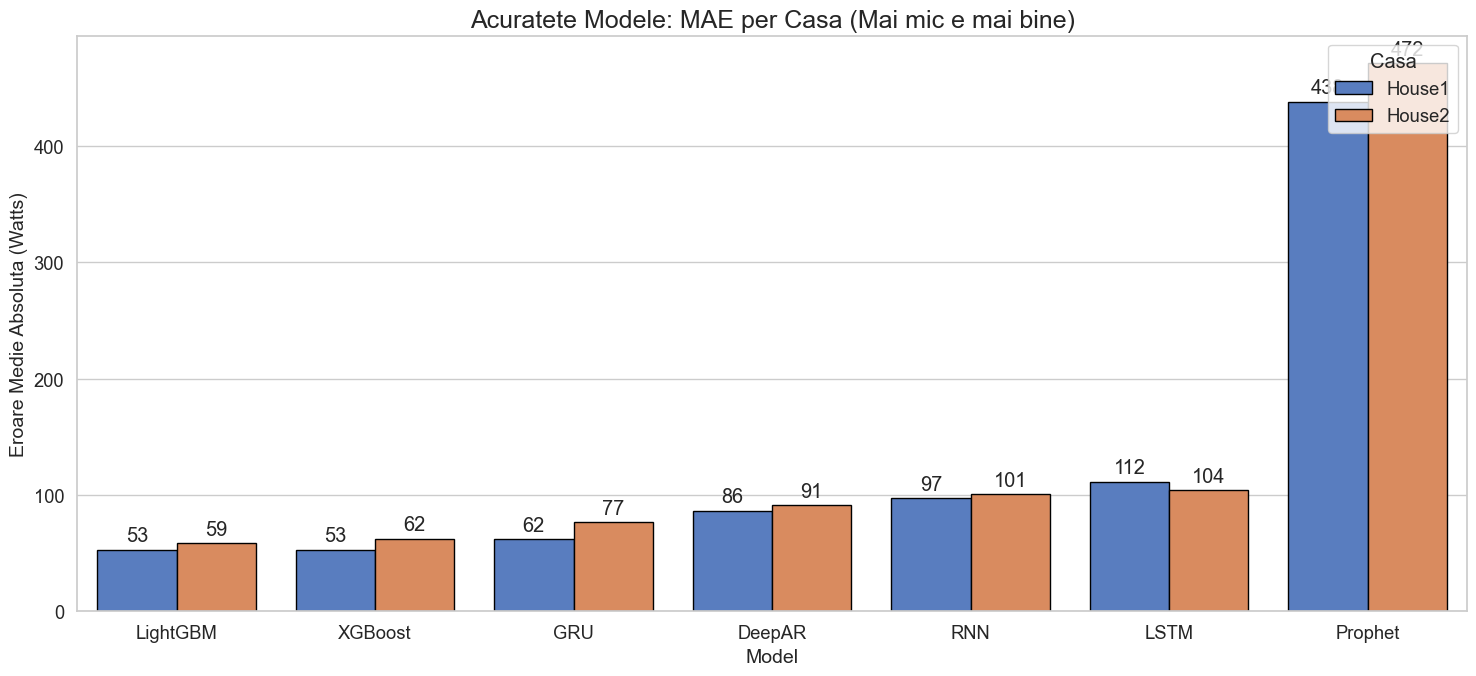

In [54]:
plt.figure(figsize=(15, 7))

# Barplot grupat
ax = sns.barplot(x='Model', y='MAE (W)', hue='Casa', data=df_results, 
                 order=order, palette='muted', edgecolor='black')

plt.title('Acuratete Modele: MAE per Casa (Mai mic e mai bine)', fontsize=18)
plt.ylabel('Eroare Medie Absoluta (Watts)', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.legend(title='Casa', loc='upper right')

# Adaugam valori pe bare
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', padding=3)

plt.tight_layout()
plt.show()